# Tutorial for `fromdecay` functionality
This tutorial shows how `phasespace.fromdecay` can be used.

This submodule makes it possible for `phasespace` and [`decaylanguage`](https://github.com/scikit-hep/decaylanguage/) to work together.
More generally, `fromdecay` can also be used as a high-level interface for simulating particles that can decay in multiple different ways.

In [18]:
# Import libraries
from pprint import pprint
from particle import Particle
from decaylanguage import DecFileParser, DecayChainViewer
# TODO rename
from phasespace.fulldecay import FullDecay

## Quick Intro to DecayLanguage
DecayLanguage can be used to parse and view .dec files. These files contain information about how a particle decays and with which probability. For more information about DecayLanguage and .dec files, see the [DecayLanguage](https://github.com/scikit-hep/decaylanguage) documentation.

We will begin by parsing a .dec file using DecayLanguage:

In [3]:
parser = DecFileParser('../tests/fulldecay/example_decays.dec')
parser.parse()

From the `parser` variable, one can access a certain decay for a particle using `parser.build_decay_chains`. This will be a `dict` that contains all information about how the mother particle, daughter particles etc. decay.

In [4]:
pi0_chain = parser.build_decay_chains("pi0")
pprint(pi0_chain)

{'pi0': [{'bf': 0.988228297,
          'fs': ['gamma', 'gamma'],
          'model': 'PHSP',
          'model_params': ''},
         {'bf': 0.011738247,
          'fs': ['e+', 'e-', 'gamma'],
          'model': 'PI0_DALITZ',
          'model_params': ''},
         {'bf': 3.3392e-05,
          'fs': ['e+', 'e+', 'e-', 'e-'],
          'model': 'PHSP',
          'model_params': ''},
         {'bf': 6.5e-08,
          'fs': ['e+', 'e-'],
          'model': 'PHSP',
          'model_params': ''}]}


This `dict` can also be displayed in a more human-readable way using `DecayChainViewer`: 

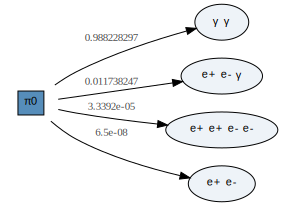

In [5]:
DecayChainViewer(pi0_chain)

## Creating a FullDecay object
A regular `phasespace.GenParticle` instance would not be able to simulate this decay, since the $\pi^0$ particle can decay in four different ways. However, a `FullDecay` object can be created directly from a DecayLanguage dict:

In [7]:
pi0_decay = FullDecay.from_dict(pi0_chain)

When creating a `FullDecay` object, the DecayLanguage dict is "unpacked" into separate GenParticle instances, where each GenParticle instance corresponds to one way that the particle can decay.

These GenParticle instances and the probabilities of that decay mode can be accessed via `FullDecay.gen_particles`. This is a list of tuples, where the first element in the tuple is the probability and the second element is the GenParticle.

In [11]:
for probability, particle in pi0_decay.gen_particles:
    print(f"There is a probability of {probability} "
          f"that pi0 decays into {', '.join(child.name for child in particle.children)}")

There is a probability of 0.988228297 that pi0 decays into gamma, gamma [0]
There is a probability of 0.011738247 that pi0 decays into e+, e-, gamma [1]
There is a probability of 3.3392e-05 that pi0 decays into e+ [0], e+ [1], e- [0], e- [1]
There is a probability of 6.5e-08 that pi0 decays into e+ [2], e- [2]


One can simulate this decay using the `.generate` method, which works the same as the `GenParticle.generate` method.

When calling the `FullDecay.generate` method, it internally calls the generate method on the of the GenParticle instances in `FullDecay.gen_particles`. The outputs are placed in a list, which is returned.

In [16]:
weights, events = pi0_decay.generate(n_events=10_000)
print("Number of events for each decay mode:", ", ".join(str(len(w)) for w in weights))

Number of events for each decay mode: 9888, 112


We can confirm that the counts above are close to the expected counts based on the probabilities. 

## Changing mass settings FullDecay
Since DecayLanguage dicts do not contain any information about the mass of a particle, the `fromdecay` submodule uses the [particle](https://github.com/scikit-hep/particle) package to find the mass of a particle based on its name. 
The mass can either be a constant value or a function (besides the top particle, which is always a constant). 
These settings can be modified by passing in additional parameters to `FullDecay.from_dict`.
There are two optional parameters that can be passed to `FullDecay.from_dict`: `tolerance` and `mass_converter`.

### tolerance
If a particle has a width less than `tolerance`, its mass is set to a constant value.
This will be demonsttrated with the decay below:

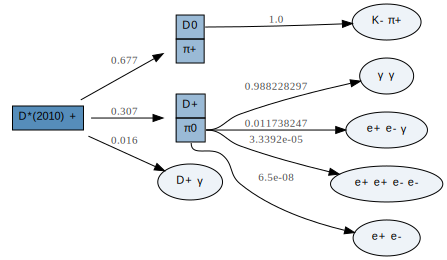

In [26]:
dsplus_chain = parser.build_decay_chains("D*+", stable_particles=["D+"])
DecayChainViewer(dsplus_chain)

In [39]:
print(f"pi0 width = {Particle.from_evtgen_name('pi0').width}\n"
      f"D0 width = {Particle.from_evtgen_name('D0').width}")

pi0 width = 7.81e-06
D0 width = 1.605e-09


$\pi^0$ has a greater width than $D^0$. 
If the tolerance is set to a value between their widths, the $D^0$ particle will have a constant mass while $\pi^0$ will not.  

In [44]:
dstar_decay = FullDecay.from_dict(dsplus_chain, tolerance=1e-8)
# Loop over D0 and pi+ particles, see graph above
for particle in dstar_decay.gen_particles[0][1].children:
    # If a particle width is less than tolerance or if it does not have any children, its mass will be fixed.
    assert particle.has_fixed_mass
    
# Loop over D+ and pi0. See above.
for particle in dstar_decay.gen_particles[1][1].children:
    if particle.name == "pi0":
        assert not particle.has_fixed_mass

### mass_converter
By default, the mass function used for variable mass is the relativistic Breit-Wigner distribution. This can however be changed.

In [45]:
# TODO add more about mass functions, the zfit parameter